In [1]:
import pandas as pd

In [5]:
week1 = pd.read_csv("voronoi1.csv")
week2 = pd.read_csv("voronoi2.csv")
week3 = pd.read_csv("voronoi3.csv")
week4 = pd.read_csv("voronoi4.csv")
week5 = pd.read_csv("voronoi5.csv")
week6 = pd.read_csv("voronoi6.csv")
week7 = pd.read_csv("voronoi7.csv")
week9 = pd.read_csv("voronoi9.csv")

In [429]:
dfs = [week1,week2,week3,week4,week5,week6,week7,week9]
final_df = pd.concat(dfs, ignore_index=True)
voronoi_df = final_df[['gameId','playId','routeRunnerId','maxValueOfSeparation']]

In [2]:
df = pd.read_csv("allVoronoi.csv")

In [431]:
df = df.iloc[:,1:]

In [432]:
df = pd.merge(
    df,
    voronoi_df,
    how ="left",
    left_on=['gameId','playId','nflId'],
    right_on = ['gameId','playId','routeRunnerId']
)

In [433]:
df[(df['gameId']==2022090800)&(df['playId']==550)]

,gameId,playId,nflId,motionSinceLineset,inMotionAtBallSnap,wasRunningRoute,wasTargettedReceiver,down,yardsToGo,offenseFormation,...,absoluteYardlineNumber,y,topOfLine,bottomOfLine,position,Unnamed: 0,safetyTop,safetyBottom,routeRunnerId,maxValueOfSeparation
1,2022090800,550,42489,True,True,1.0,0,2,3,SHOTGUN,...,94,38.71,32.51,25.85,WR,1854.0,1.0,1.0,NaN,NaN
100,2022090800,550,44985,False,False,1.0,0,2,3,SHOTGUN,...,94,18.32,32.51,25.85,WR,1854.0,1.0,1.0,NaN,NaN
159,2022090800,550,47879,False,False,1.0,0,2,3,SHOTGUN,...,94,34.35,32.51,25.85,TE,1854.0,1.0,1.0,NaN,NaN
233,2022090800,550,52536,False,False,1.0,0,2,3,SHOTGUN,...,94,11.33,32.51,25.85,WR,1854.0,1.0,1.0,NaN,NaN
706,2022090800,550,47857,False,False,1.0,0,2,3,SHOTGUN,...,94,32.26,32.51,25.85,RB,1854.0,1.0,1.0,NaN,NaN


In [434]:
df = df.dropna()

In [435]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [436]:
playerplays = pd.read_csv('player_play.csv')

In [437]:
df = pd.merge(
    df,
    playerplays[['gameId','playId','nflId','routeRan']],
    how = "left",
    on=['gameId','playId','nflId']
)

In [457]:
one = pd.DataFrame(columns=[
    'gameId', 'playId', 'down', 'yardsToGo', 'offenseFormation', 
    'pff_passCoverage', 'absoluteYardlineNumber', 'receiverAlignment',
    'firstY', 'secondY', 'thirdY', 'fourthY', 'fifthY', 'sixthY', 'firstRoute','secondRoute','thirdRoute','fourthRoute','fifthRoute','safetyTop','safetyBottom', 'rbPosition',
    'aboveLine', 'belowLine','motionReceiver', 'motionCluster', 'inMotionAtBallSnap', 
    'targetedReceiver', 'maxSeparationReceiver', 'nflId'
])

for _, i in df.iterrows():
    inone = ((one['gameId'] == i['gameId']) & (one['playId'] == i['playId'])).any()
    
    if not inone:
        play = df[(df['gameId'] == i['gameId']) & 
                       (df['playId'] == i['playId'])]
        play = play.sort_values(by='y', ascending=False)
        motion_players = play[play['motionSinceLineset']]  # Get motion players

        for _, motion_player in motion_players.iterrows():
            thisplay = [
                i['gameId'],
                i['playId'],
                i['down'], 
                i['yardsToGo'], 
                i['offenseFormation'],
                i['pff_passCoverage'], 
                i['absoluteYardlineNumber'],
                i['receiverAlignment']
            ]

            motionrec = 0
            targetrec = 0
            motionindex = 1
            targetindex = 1
            aboveline = 0
            belowline = 0
            moving = False
            rbindex = 0
            maxseparationrec = 0
            max = 0
            for _, j in play.iterrows():
                thisplay.append(j['y'])
                if j['y'] > j['topOfLine']:
                    aboveline += 1
                elif j['y'] < j['bottomOfLine']:
                    belowline += 1
                if j['motionSinceLineset']:
                    if j['nflId'] == motion_player['nflId']:  # Focus on specific motion player
                        motionrec = motionindex
                        if j['inMotionAtBallSnap']:
                            moving = True
                if j['position'] == 'RB':
                    rbindex = targetindex
                if j['wasTargettedReceiver']:
                    targetrec = targetindex
                if j['maxValueOfSeparation'] > max:
                    max = j['maxValueOfSeparation']
                    maxseparationrec = targetindex
                motionindex += 1
                targetindex += 1
            
            

            while len(thisplay) < 14:
                thisplay.append(0)
            
            for _, j in play.iterrows():
                thisplay.append(j['routeRan'])

            while len(thisplay) < 19:
                thisplay.append(0)

            

            thisplay.extend([
                i['safetyTop'],
                i['safetyBottom'],
                rbindex,
                aboveline,
                belowline,
                motionrec,
                0,  # Add motion cluster
                moving,
                targetrec,
                maxseparationrec,  # Find max separation receiver
                motion_player['nflId']
            ])
            
            new_row = pd.DataFrame([thisplay], columns=one.columns)
            one = pd.concat([one, new_row], ignore_index=True)


C:\Users\bhaga\AppData\Local\Temp\ipykernel_32248\586826005.py:89: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  one = pd.concat([one, new_row], ignore_index=True)


In [458]:
one = one[one['thirdY']!=0]

In [ ]:
clusters = pd.read_csv("clusters.csv")

In [462]:
one = pd.merge(
    one,
    clusters[['gameId','playId','nflId', 'cluster']],
    how = "left",
    on = ['gameId','playId','nflId']
)

In [463]:
one = one[one['cluster'].notna()]

In [464]:
one['motionCluster'] = one['cluster']

Random Forest

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [542]:
X = one.drop(columns = ['gameId','playId','nflId','targetedReceiver','maxSeparationReceiver', 'cluster', 'receiverAlignment', 'sixthY'])

In [467]:
y = one['maxSeparationReceiver']

In [468]:
y = y.astype("category")

In [469]:
X

,down,yardsToGo,offenseFormation,pff_passCoverage,absoluteYardlineNumber,firstY,secondY,thirdY,fourthY,fifthY,...,fourthRoute,fifthRoute,safetyTop,safetyBottom,rbPosition,aboveLine,belowLine,motionReceiver,motionCluster,inMotionAtBallSnap
0,1,10,SHOTGUN,Cover 6-Left,85,43.65,34.37,18.20,8.25,0,...,GO,0,1.0,2.0,0,2,2,1,5.0,False
1,3,4,SHOTGUN,Cover-3,95,34.99,34.61,26.97,18.19,10.38,...,GO,GO,1.0,1.0,3,2,2,1,3.0,True
2,1,10,SHOTGUN,Cover-3,74,34.55,25.55,21.53,14.89,0,...,IN,0,2.0,1.0,0,1,1,3,3.0,True
3,3,2,SHOTGUN,Cover-3,50,42.03,26.77,26.19,18.16,9.36,...,GO,HITCH,0.0,2.0,3,1,2,2,2.0,True
4,1,10,SHOTGUN,Cover-3 Seam,32,43.64,34.90,26.09,17.15,8.17,...,IN,HITCH,1.0,1.0,3,2,2,5,2.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2853,3,6,SHOTGUN,Cover-1,67,38.03,35.65,30.28,21.88,16.64,...,FLAT,CROSS,1.0,1.0,4,3,1,2,3.0,True
2854,4,3,SHOTGUN,Cover-1,85,43.95,35.12,31.33,21.79,9.23,...,FLAT,GO,0.0,2.0,4,3,2,3,1.0,False
2855,3,2,SINGLEBACK,Cover-3,40,33.99,29.91,23.98,21.94,0,...,CROSS,0,1.0,1.0,2,1,2,4,6.0,True
2856,1,10,SHOTGUN,Cover-2,50,42.48,30.85,26.46,16.43,10.69,...,HITCH,HITCH,1.0,1.0,3,2,2,1,5.0,False


In [543]:
X_dummies = pd.get_dummies(X, columns=['down','rbPosition','offenseFormation','motionReceiver','motionCluster', 'pff_passCoverage', 'firstRoute','secondRoute','thirdRoute','fourthRoute','fifthRoute'])

In [471]:
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.3, random_state=42)

In [472]:
y.value_counts()

maxSeparationReceiver
1    788
5    538
4    484
2    459
3    393
Name: count, dtype: int64

In [473]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=30, class_weight="balanced")

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=30, random_state=42)

In [474]:
print("Accuracy:", accuracy_score(y_train, rf.predict(X_train)))

Accuracy: 1.0


In [475]:
print("Accuracy:", accuracy_score(y_test, rf.predict(X_test)))

Accuracy: 0.5068836045056321


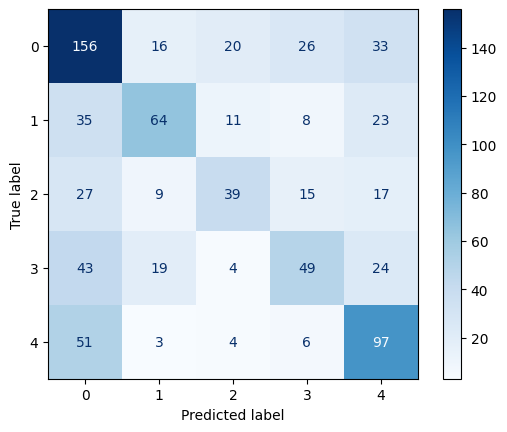

In [476]:
cm_best = confusion_matrix(y_test, rf.predict(X_test))
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best)
disp_best.plot(cmap='Blues')

In [148]:
from imblearn.over_sampling import SMOTE

In [481]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [552]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=8, class_weight="balanced_subsample")

rf.fit(X_resampled, y_resampled)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=8,
                       random_state=42)

In [553]:
print("Accuracy:", accuracy_score(y_train, rf.predict(X_train)))

Accuracy: 0.725174449812131


In [554]:
print("Accuracy:", accuracy_score(y_test, rf.predict(X_test)))

Accuracy: 0.43178973717146435


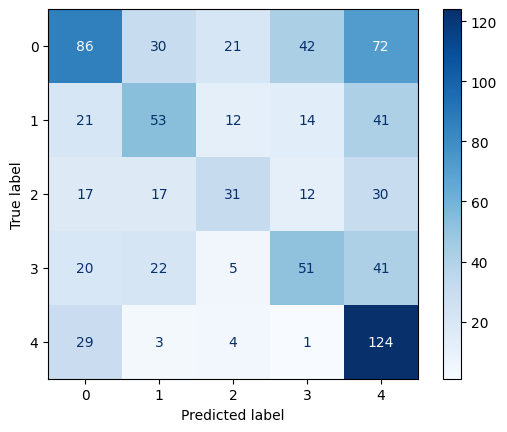

In [555]:
cm_best = confusion_matrix(y_test, rf.predict(X_test))
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best)
disp_best.plot(cmap='Blues')

In [311]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],          # Number of trees in the forest.
    'max_depth': [None, 10, 20, 30],         
    'max_features': ['sqrt', 'log2'],       
    'bootstrap': [True, False]              
}

In [387]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(RandomForestClassifier(), 
                           param_grid=param_grid) 
grid_search.fit(X_resampled, y_resampled) 
print(grid_search.best_estimator_) 

RandomForestClassifier(bootstrap=False, max_depth=20, max_features='log2',
                       n_estimators=200)


In [ ]:
rf_model_best = RandomForestClassifier(max_depth=8,
                                       n_estimators=200,
                                       max_features="log2",
                                    random_state=42) 
rf_model_best.fit(X_resampled, y_resampled) 

RandomForestClassifier(max_depth=8, max_features='log2', n_estimators=200,
                       random_state=42)

In [535]:
print("Accuracy:", accuracy_score(y_train, rf_model_best.predict(X_train)))
print("Accuracy:", accuracy_score(y_test, rf_model_best.predict(X_test)))

Accuracy: 0.7332259796027912
Accuracy: 0.4330413016270338


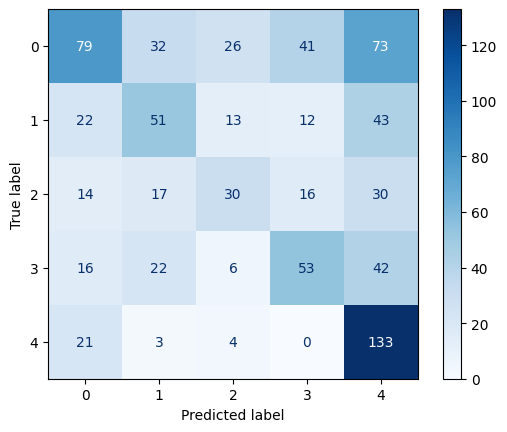

In [531]:
cm_best = confusion_matrix(y_test, rf_model_best.predict(X_test))
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best)
disp_best.plot(cmap='Blues')

In [346]:
feature_importances = rf_model_best.feature_importances_
important = pd.DataFrame()
for name, importance in zip(X_train.columns, feature_importances):
    important = pd.concat([important, pd.DataFrame({'Name': [name], 'Importance': [importance]})], ignore_index=True)

important = important.sort_values(by='Importance', ascending=False)

In [348]:
important.head(50)

,Name,Importance
5,fourthY,0.054281
2,firstY,0.050886
4,thirdY,0.050664
1,absoluteYardlineNumber,0.048641
3,secondY,0.047836
6,fifthY,0.043907
0,yardsToGo,0.033353
10,belowLine,0.020293
9,aboveLine,0.019398
111,fifthRoute_GO,0.018392


XGBoost

In [494]:
y = y.cat.codes

In [560]:
X = pd.get_dummies(X, columns=['down','offenseFormation','rbPosition','pff_passCoverage','motionReceiver','motionCluster', 'firstRoute','secondRoute','thirdRoute','fourthRoute','fifthRoute'])

In [501]:
bool_cols = ['yardsToGo', 'absoluteYardlineNumber', 'fifthY', 'aboveLine', 'belowLine', 'inMotionAtBallSnap']  # Add other boolean columns as needed
X[bool_cols] = X[bool_cols].astype(int)

In [502]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [353]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [354]:
class_counts = y_train.value_counts()
scale_pos_weight = class_counts.max() / class_counts.min()

In [513]:
model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=5,
    eval_metric='merror',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    gamma=0, 
    subsample=0.8,
    colsample_bytree=0.8,
    random_state = 42
)

model.fit(X_train, y_train)

c:\Users\bhaga\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:05:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='merror',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

In [514]:
accuracy = accuracy_score(y_train, model.predict(X_train))
print(f"Training Accuracy: {accuracy:.2f}")

accuracy = accuracy_score(y_test, model.predict(X_test))
print(f"Testing Accuracy: {accuracy:.2f}")

Training Accuracy: 0.66
Testing Accuracy: 0.46


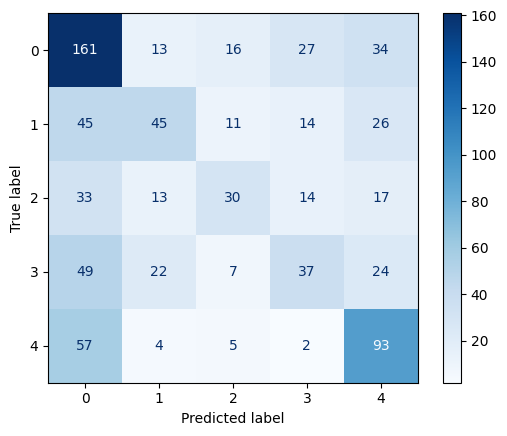

In [515]:
cm_best = confusion_matrix(y_test, model.predict(X_test))
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best)
disp_best.plot(cmap='Blues')

In [506]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [522]:
model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=5,
    eval_metric='merror',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    gamma=0, 
    subsample=0.8,
    colsample_bytree=0.8,
    random_state = 42
)

model.fit(X_resampled, y_resampled)

c:\Users\bhaga\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:06:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='merror',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

In [523]:
accuracy = accuracy_score(y_train, model.predict(X_train))
print(f"Training Accuracy: {accuracy:.2f}")

accuracy = accuracy_score(y_test, model.predict(X_test))
print(f"Testing Accuracy: {accuracy:.2f}")

Training Accuracy: 0.63
Testing Accuracy: 0.43


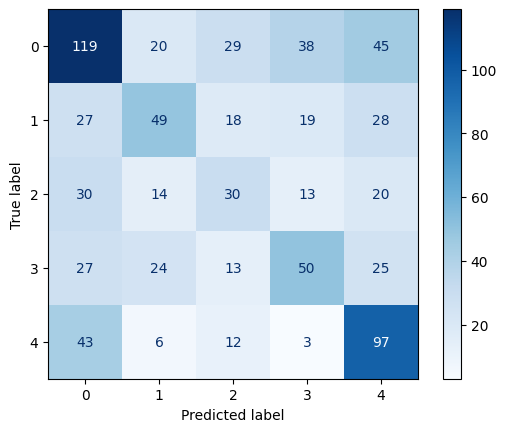

In [524]:
cm_best = confusion_matrix(y_test, model.predict(X_test))
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best)
disp_best.plot(cmap='Blues')

Model Comparison

In [556]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, rf.predict(X_test))
from sklearn.metrics import precision_score
precision = precision_score(y_test, rf.predict(X_test), average='weighted')
from sklearn.metrics import recall_score
recall = recall_score(y_test, rf.predict(X_test), average='weighted')
from sklearn.metrics import f1_score
f1 = f1_score(y_test, rf.predict(X_test), average='weighted')
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, rf.predict_proba(X_test), multi_class='ovr')


In [557]:
print(f"Accuracy: {accuracy}")
print(f"precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
print(f"AUC: {auc}")

Accuracy: 0.43178973717146435
precision: 0.44291627591558674
Recall: 0.43178973717146435
F1: 0.4189485873552821
AUC: 0.7571428449693112


In [538]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, model.predict(X_test))
from sklearn.metrics import precision_score
precision = precision_score(y_test, model.predict(X_test), average='weighted')
from sklearn.metrics import recall_score
recall = recall_score(y_test, model.predict(X_test), average='weighted')
from sklearn.metrics import f1_score
f1 = f1_score(y_test, model.predict(X_test), average='weighted')
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')


In [539]:
print(f"Accuracy: {accuracy}")
print(f"precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
print(f"AUC: {auc}")

Accuracy: 0.43178973717146435
precision: 0.4295020709457021
Recall: 0.43178973717146435
F1: 0.42733297284317584
AUC: 0.7610860002452723


Analysis

In [362]:
X

,yardsToGo,absoluteYardlineNumber,firstY,secondY,thirdY,fourthY,fifthY,safetyTop,safetyBottom,aboveLine,...,fifthRoute_CORNER,fifthRoute_CROSS,fifthRoute_FLAT,fifthRoute_GO,fifthRoute_HITCH,fifthRoute_IN,fifthRoute_OUT,fifthRoute_POST,fifthRoute_SCREEN,fifthRoute_SLANT
0,10,85,43.65,34.37,18.20,8.25,0,1.0,2.0,2,...,False,False,False,False,False,False,False,False,False,False
1,4,95,34.99,34.61,26.97,18.19,10,1.0,1.0,2,...,False,False,False,True,False,False,False,False,False,False
2,10,74,34.55,25.55,21.53,14.89,0,2.0,1.0,1,...,False,False,False,False,False,False,False,False,False,False
3,2,50,42.03,26.77,26.19,18.16,9,0.0,2.0,1,...,False,False,False,False,True,False,False,False,False,False
4,10,32,43.64,34.90,26.09,17.15,8,1.0,1.0,2,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2853,6,67,38.03,35.65,30.28,21.88,16,1.0,1.0,3,...,False,True,False,False,False,False,False,False,False,False
2854,3,85,43.95,35.12,31.33,21.79,9,0.0,2.0,3,...,False,False,False,True,False,False,False,False,False,False
2855,2,40,33.99,29.91,23.98,21.94,0,1.0,1.0,1,...,False,False,False,False,False,False,False,False,False,False
2856,10,50,42.48,30.85,26.46,16.43,10,1.0,1.0,2,...,False,False,False,False,True,False,False,False,False,False


In [561]:
allpreds = rf.predict(X)

In [564]:
one['maxExpectedReceiver'] = allpreds+1

In [655]:
info = one[['gameId','playId','nflId','motionReceiver','motionCluster','pff_passCoverage','offenseFormation','receiverAlignment','maxExpectedReceiver', 'maxSeparationReceiver','targetedReceiver']]

In [656]:
teams = playerplays[['nflId','teamAbbr']].drop_duplicates()

In [657]:
info = pd.merge(
    info,
    teams,
    how = 'left',
    on = 'nflId'
)

In [658]:
info['motionMax'] = (info['motionReceiver'] == info['maxExpectedReceiver']).astype(int)

In [659]:
info['motionTarget'] = (info['motionReceiver'] == info['targetedReceiver']).astype(int)

In [660]:
info = pd.merge(
    info,
    voronoi_df,
    how = "left",
    left_on = ['gameId','playId','nflId'],
    right_on = ['gameId','playId','routeRunnerId']
)
info = info.drop(columns=['routeRunnerId'])

In [662]:
info.to_csv("findings.csv")

In [663]:
players = pd.read_csv("players.csv")
players = players[['nflId','displayName']]

In [621]:
players

,nflId,displayName
0,25511,Tom Brady
1,29550,Jason Peters
2,29851,Aaron Rodgers
3,30842,Marcedes Lewis
4,33084,Matt Ryan
...,...,...
1692,55190,Sam Okuayinonu
1693,55200,Ryder Anderson
1694,55239,Prince Emili
1695,55240,Ja'Marcus Ingram


Against Which Coverages Should Motion Receivers Be Targets

In [664]:
coverage_motion_table = info.pivot_table(
    index='pff_passCoverage',          
    columns='motionCluster',           
    values='motionMax',                
    aggfunc='mean'                     
)


coverage_motion_table


motionCluster,0.0,1.0,2.0,3.0,4.0,5.0,6.0
pff_passCoverage,,,,,,,
2-Man,0.100000,0.000000,0.000000,0.200000,0.000000,0.200000,0.285714
Bracket,0.500000,0.000000,0.333333,0.000000,NaN,0.000000,0.333333
Cover 6-Left,0.380952,0.133333,0.157895,0.444444,0.000000,0.285714,0.100000
Cover-0,0.333333,0.333333,0.269231,0.250000,0.250000,0.250000,0.272727
Cover-1,0.250000,0.149425,0.300000,0.207317,0.144330,0.184211,0.301075
Cover-1 Double,1.000000,0.000000,0.000000,0.000000,0.000000,0.500000,1.000000
Cover-2,0.166667,0.243243,0.245902,0.173913,0.129630,0.244898,0.213115
Cover-3,0.207921,0.171053,0.300000,0.358696,0.134921,0.194444,0.330827
Cover-3 Cloud Left,1.000000,0.000000,0.500000,0.000000,0.000000,NaN,NaN


In [666]:
coverage_motion_table.to_csv("coverage_motion.csv")

Which Teams are Using Motion as a Decoy

In [622]:
coverage_motion_table = info.pivot_table(
    index='teamAbbr',          
    columns='motionCluster',          
    values='motionTarget',                
    aggfunc='mean'                     
)

coverage_motion_table['Overall'] = coverage_motion_table.mean(axis=1)


coverage_motion_table.sort_values(by='Overall')


motionCluster,0.0,1.0,2.0,3.0,4.0,5.0,6.0,Overall
teamAbbr,,,,,,,,
MIA,0.160000,0.142857,0.166667,0.236842,0.142857,0.181818,0.269231,0.185753
DEN,0.363636,0.500000,0.000000,0.000000,0.000000,0.200000,0.333333,0.199567
CLE,0.083333,0.200000,0.461538,0.200000,0.285714,0.105263,0.066667,0.200359
CHI,0.000000,0.285714,0.450000,0.000000,0.125000,0.333333,0.250000,0.206293
BAL,0.291667,0.375000,0.000000,0.222222,0.125000,0.333333,0.166667,0.216270
TEN,0.166667,0.111111,0.200000,0.000000,0.375000,0.428571,0.250000,0.218764
IND,0.533333,0.125000,0.000000,0.200000,0.111111,0.384615,0.187500,0.220223
DET,0.200000,0.200000,0.294118,0.157895,0.321429,0.235294,0.250000,0.236962
MIN,0.125000,0.235294,0.500000,0.125000,0.320000,0.214286,0.166667,0.240892


How Often Are Teams Targeting Their Motion Man and Should They Look Elsewhere

In [596]:
coverage_motion_table = info.pivot_table(
    index='teamAbbr',          
    columns='motionMax',          
    values='motionTarget',                
    aggfunc='mean'                     
)


coverage_motion_table


motionMax,0,1
teamAbbr,,
ARI,0.333333,0.428571
ATL,0.231884,0.222222
BAL,0.255319,0.304348
BUF,0.323232,0.357143
CAR,0.333333,0.400000
CHI,0.234375,0.428571
CIN,0.250000,0.363636
CLE,0.189873,0.225806
DAL,0.271186,0.400000


How often did players in motion not get open when they were expected to

In [667]:
motionInfo = info
motionInfo['separationCategory'] = pd.cut(
    motionInfo['maxValueOfSeparation'],
    bins=[-float('inf'), 50, 100, 150, float('inf')],  # Define the bin edges
    labels=["Not open", "Moderately open", "Open", "Wide open"]  # Define the labels
)
coverage_motion_table1 = motionInfo.pivot_table(
    index='nflId',          
    columns='separationCategory',          
    values='gameId',                
    aggfunc='count'                     
)
coverage_motion_table_percentage1 = coverage_motion_table.div(coverage_motion_table.sum(axis=1), axis=0)

In [668]:
motionMaxInfo = info[info['motionMax']==1]
motionMaxInfo['separationCategory'] = pd.cut(
    motionMaxInfo['maxValueOfSeparation'],
    bins=[-float('inf'), 50, 100, 150, float('inf')],  # Define the bin edges
    labels=["Not open", "Moderately open", "Open", "Wide open"]  # Define the labels
)
coverage_motion_table = motionMaxInfo.pivot_table(
    index='nflId',          
    columns='separationCategory',          
    values='gameId',                
    aggfunc='count'                     
)


coverage_motion_table_percentage = coverage_motion_table.div(coverage_motion_table.sum(axis=1), axis=0)

C:\Users\bhaga\AppData\Local\Temp\ipykernel_32248\127229729.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  motionMaxInfo['separationCategory'] = pd.cut(


**Need to decide whether to look at count or percent or combo**

In [669]:
coverage_motion_table_reset1 = coverage_motion_table1.reset_index()

# Merge the reset pivot table with the players DataFrame
merged_table1 = pd.merge(
    coverage_motion_table_reset1,  # Reset pivot table
    players,                      # Players DataFrame
    how="left",                   # Left join
    on="nflId"                    # Merge on nflId
)
merged_table1 = merged_table1[['displayName','Not open','Moderately open','Open','Wide open']]

In [670]:
merged_table1.sort_values(
    by="Not open", ascending=False
)

,displayName,Not open,Moderately open,Open,Wide open
224,Chase Claypool,24,4,2,4
161,T.J. Hockenson,24,24,6,4
77,Christian McCaffrey,22,6,2,0
14,Travis Kelce,19,18,4,3
140,Tyler Conklin,14,5,4,2
...,...,...,...,...,...
44,Mike Davis,0,1,0,0
113,Tanner Gentry,0,0,1,0
45,MyCole Pruitt,0,1,0,0
223,K.J. Hamler,0,3,2,0


In [671]:
merged_table1.sort_values(
    by="Wide open", ascending=False
)

,displayName,Not open,Moderately open,Open,Wide open
20,Adam Thielen,6,9,7,8
134,Nyheim Hines,10,10,8,6
46,Stefon Diggs,11,18,1,5
67,Tyreek Hill,9,18,4,5
152,Jeffery Wilson,4,4,6,4
...,...,...,...,...,...
160,KhaDarel Hodge,2,0,1,0
162,Noah Fant,3,5,0,0
164,Marquise Brown,0,2,1,0
165,N'Keal Harry,0,1,0,0


In [672]:
merged_table1['rating'] = ((merged_table1['Not open']*-1) + (merged_table1['Moderately open']*0) + (merged_table1['Open']*1) + (merged_table1['Wide open']*2))/(merged_table1['Not open'] + merged_table1['Moderately open'] + merged_table1['Open'] + merged_table1['Wide open'])
merged_table = merged_table1[
    (merged_table1['Not open'] + merged_table1['Moderately open'] + merged_table1['Open'] + merged_table1['Wide open']) > 3
]
merged_table.sort_values(
    by="rating", ascending=False
)

,displayName,Not open,Moderately open,Open,Wide open,rating
7,Marvin Jones,0,1,2,2,1.200000
240,Colby Parkinson,1,1,3,4,1.111111
233,Devin Duvernay,0,3,5,2,0.900000
189,Darius Slayton,1,1,0,2,0.750000
40,Tevin Coleman,0,2,1,1,0.750000
...,...,...,...,...,...,...
227,A.J. Dillon,5,1,0,0,-0.833333
47,C.J. Uzomah,5,1,0,0,-0.833333
340,Jake Ferguson,4,0,0,0,-1.000000
234,Josiah Deguara,4,0,0,0,-1.000000


In [673]:
merged_table.to_csv("best_motioners.csv")

In [674]:
coverage_motion_table_reset = coverage_motion_table.reset_index()

# Merge the reset pivot table with the players DataFrame
merged_table = pd.merge(
    coverage_motion_table_reset,  # Reset pivot table
    players,                      # Players DataFrame
    how="left",                   # Left join
    on="nflId"                    # Merge on nflId
)
merged_table = merged_table[['displayName','Not open','Moderately open','Open','Wide open']]

In [675]:
merged_table.sort_values(
    by="Not open", ascending=False
)

,displayName,Not open,Moderately open,Open,Wide open
111,T.J. Hockenson,4,6,0,4
178,James Robinson,2,0,0,0
203,Amon-Ra St. Brown,2,0,4,0
119,Miles Sanders,2,0,0,0
186,Kadarius Toney,2,2,0,0
...,...,...,...,...,...
91,Will Dissly,0,2,1,0
92,Chase Edmonds,0,1,2,0
93,Tyler Conklin,0,0,0,1
95,Marquez Valdes-Scantling,0,1,0,0


In [676]:
merged_table.sort_values(
    by="Wide open", ascending=False
)

,displayName,Not open,Moderately open,Open,Wide open
12,Adam Thielen,0,4,2,5
111,T.J. Hockenson,4,6,0,4
40,Tyreek Hill,0,6,2,3
190,Elijah Moore,0,2,3,3
58,Chris Godwin,1,2,1,3
...,...,...,...,...,...
103,Jeffery Wilson,0,2,6,0
104,Dontrell Hilliard,0,2,0,0
106,Trent Sherfield,0,2,1,0
107,Allen Lazard,2,2,1,0


In [677]:
merged_table['rating'] = ((merged_table['Not open']*-1) + (merged_table['Moderately open']*0) + (merged_table['Open']*1) + (merged_table['Wide open']*2))/(merged_table['Not open'] + merged_table['Moderately open'] + merged_table['Open'] + merged_table['Wide open'])
merged_table = merged_table[
    (merged_table['Not open'] + merged_table['Moderately open'] + merged_table['Open'] + merged_table['Wide open']) > 3
]
merged_table.sort_values(
    by="rating", ascending=False
)

,displayName,Not open,Moderately open,Open,Wide open,rating
80,D.J. Moore,0,1,1,3,1.400000
15,Davante Adams,0,0,3,1,1.250000
7,Travis Kelce,0,1,2,2,1.200000
36,Kenyan Drake,0,1,3,2,1.166667
190,Elijah Moore,0,2,3,3,1.125000
12,Adam Thielen,0,4,2,5,1.090909
47,Corey Davis,0,2,0,2,1.000000
167,Colby Parkinson,1,0,2,2,1.000000
19,Amari Cooper,0,1,2,1,1.000000
196,Josh Palmer,0,2,1,2,1.000000
